# National Mangrove Backbone: Blue Carbon AOI Preparation

## Objective

This notebook operationalizes the blue carbon strategy for Colombia by loading, inspecting, and analyzing mangrove AOIs derived from the 1:100k national ecosystem map (2024). We compute strategic metrics per hydrographic zone, assign flagship/emerging/exploratory status, and export priority AOIs for downstream analysis on Earthm.ai.

**Outputs:**
- Strategic summary table: `data/processed/blue_carbon_candidates.csv`
- Individual AOI GeoJSON files: `data/processed/aois/`
- AOI metadata: `ai_docs/blue_carbon_aoi_metadata.csv`

## Setup

In [1]:
# -----------------------------------------------------------------------------
# Configuration Block
# -----------------------------------------------------------------------------
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Paths (relative to repo root, assuming notebook is run from notebooks/)
REPO_ROOT = Path('..').resolve()
DATA_PROCESSED = REPO_ROOT / 'data' / 'processed'
DATA_AOIS = DATA_PROCESSED / 'aois'
AI_DOCS = REPO_ROOT / 'ai_docs'

# Input files
MANGROVES_ALL = DATA_PROCESSED / 'mangroves_colombia_100k_2024.geojson'
MANGROVES_DISSOLVED = DATA_PROCESSED / 'mangroves_colombia_100k_2024_dissolved.geojson'
MANGROVES_BY_NOM_ZH = DATA_PROCESSED / 'mangroves_colombia_100k_2024_by_nom_zh.geojson'

# Output files
CANDIDATES_CSV = DATA_PROCESSED / 'blue_carbon_candidates.csv'
METADATA_CSV = AI_DOCS / 'blue_carbon_aoi_metadata.csv'

# CRS Configuration
CRS_ORIGINAL = 'EPSG:4686'  # MAGNA-SIRGAS geographic
CRS_EQUAL_AREA = 'EPSG:3116'  # MAGNA-SIRGAS / Colombia Bogota zone (for area calculations)
CRS_WGS84 = 'EPSG:4326'  # For interoperability

# Source data reference
SOURCE_LAYER = 'e_eccmc_100K_2024.shp'
FILTER_LOGIC = "u_sintesis contains 'manglar' (case-insensitive)"

# Flagship zones definition (based on blue carbon strategy)
FLAGSHIP_ZONES = ['Sinu', 'Bajo Magdalena', 'Patia', 'Mira']
EMERGING_ZONES = ['San Juan', 'Pacifico - Directos', 'Atrato - Darien', 'Tapaje - Dagua - Directos']

# Priority scoring parameters
FLAGSHIP_BONUS = 0.3
EMERGING_BONUS = 0.15

# Ensure output directories exist
DATA_AOIS.mkdir(parents=True, exist_ok=True)

print(f"Repository root: {REPO_ROOT}")
print(f"Data processed: {DATA_PROCESSED}")
print(f"AOIs output: {DATA_AOIS}")

Repository root: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data
Data processed: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed
AOIs output: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/aois


In [2]:
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import unicodedata
import re

# Check versions for reproducibility
print(f"geopandas version: {gpd.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"Processing date: {datetime.now().isoformat()}")

geopandas version: 1.1.1
pandas version: 2.2.3
Processing date: 2025-11-26T11:10:43.706234


## 1. Data Loading & Validation

In [3]:
# -----------------------------------------------------------------------------
# Load all three processed GeoJSON files
# -----------------------------------------------------------------------------

# 1. All mangrove polygons (detailed)
gdf_all = gpd.read_file(MANGROVES_ALL)

# 2. Dissolved national mangrove extent (single geometry)
gdf_dissolved = gpd.read_file(MANGROVES_DISSOLVED)

# 3. Mangroves grouped by hydrographic zone (nom_zh)
gdf_by_zh = gpd.read_file(MANGROVES_BY_NOM_ZH)

print("Data loaded successfully!")

Data loaded successfully!


In [4]:
# -----------------------------------------------------------------------------
# Inspect: All mangrove polygons
# -----------------------------------------------------------------------------
print("=" * 60)
print("DATASET 1: mangroves_colombia_100k_2024.geojson")
print("=" * 60)
print(f"CRS: {gdf_all.crs}")
print(f"Number of features: {len(gdf_all):,}")
print(f"Columns: {len(gdf_all.columns)}")
print(f"\nKey columns available:")
key_cols = ['OBJECTID', 'tipo_ecos', 'u_sintesis', 'nom_zh', 'area_ha']
for col in key_cols:
    if col in gdf_all.columns:
        print(f"  - {col}")
print(f"\nExample u_sintesis values:")
print(gdf_all['u_sintesis'].head(3).tolist())

DATASET 1: mangroves_colombia_100k_2024.geojson
CRS: EPSG:4686
Number of features: 1,601
Columns: 47

Key columns available:
  - OBJECTID
  - tipo_ecos
  - u_sintesis
  - nom_zh
  - area_ha

Example u_sintesis values:
['Bosque Manglar en áreas que predomina Manglar sobre Plano de marea de la Zona Hidrográfica Patía', 'Bosque Manglar en áreas que predomina Manglar sobre Plano de marea de la Zona Hidrográfica Patía', 'Bosque Manglar en áreas que predomina Manglar sobre Plano de marea de la Zona Hidrográfica Patía']


In [5]:
# -----------------------------------------------------------------------------
# Inspect: Dissolved national extent
# -----------------------------------------------------------------------------
print("=" * 60)
print("DATASET 2: mangroves_colombia_100k_2024_dissolved.geojson")
print("=" * 60)
print(f"CRS: {gdf_dissolved.crs}")
print(f"Number of features: {len(gdf_dissolved)}")
print(f"Geometry type: {gdf_dissolved.geometry.geom_type.iloc[0]}")
print("\nThis represents the national mangrove envelope for Colombia.")

DATASET 2: mangroves_colombia_100k_2024_dissolved.geojson
CRS: EPSG:4686
Number of features: 1
Geometry type: MultiPolygon

This represents the national mangrove envelope for Colombia.


In [6]:
# -----------------------------------------------------------------------------
# Inspect: Grouped by hydrographic zone (nom_zh)
# -----------------------------------------------------------------------------
print("=" * 60)
print("DATASET 3: mangroves_colombia_100k_2024_by_nom_zh.geojson")
print("=" * 60)
print(f"CRS: {gdf_by_zh.crs}")
print(f"Number of hydrographic zones: {len(gdf_by_zh)}")
print(f"\nHydrographic zones (nom_zh):")
for nom_zh in sorted(gdf_by_zh['nom_zh'].tolist()):
    print(f"  - {nom_zh}")

DATASET 3: mangroves_colombia_100k_2024_by_nom_zh.geojson
CRS: EPSG:4686
Number of hydrographic zones: 12

Hydrographic zones (nom_zh):
  - Atrato - Darién
  - Bajo Magdalena
  - Baudó - Directos Pacífico
  - Caribe - Guajira
  - Caribe - Litoral
  - Islas Caribe
  - Mira
  - Pacífico - Directos
  - Patía
  - San Juán
  - Sinú
  - Tapaje - Dagua - Directos


In [7]:
# -----------------------------------------------------------------------------
# Display example attribute rows
# -----------------------------------------------------------------------------
print("Example attribute rows from by_nom_zh dataset:")
display_cols = ['nom_zh', 'tipo_ecos', 'u_sintesis', 'area_ha']
display_cols = [c for c in display_cols if c in gdf_by_zh.columns]
gdf_by_zh[display_cols].head()

Example attribute rows from by_nom_zh dataset:


,nom_zh,tipo_ecos,u_sintesis,area_ha
0,Atrato - Darién,Costero,Bosque Manglar en áreas que predomina Manglar ...,465.433642
1,Bajo Magdalena,Costero,Bosque Inundable Basal en áreas que predomina ...,174.415434
2,Baudó - Directos Pacífico,Costero,Bosque Manglar en áreas que predomina Manglar ...,108.370332
3,Caribe - Guajira,Costero,Bosque Manglar en áreas que predomina Manglar ...,37.371729
4,Caribe - Litoral,Costero,Bosque Manglar en áreas que predomina Manglar ...,138.478700


## 2. Compute Strategic Metrics per Hydrographic AOI

In [8]:
# -----------------------------------------------------------------------------
# Helper function to normalize zone names for matching
# -----------------------------------------------------------------------------
def normalize_zone_name(name):
    """Normalize zone name by removing accents and converting to lowercase."""
    if pd.isna(name):
        return ''
    # Remove accents
    nfkd = unicodedata.normalize('NFKD', str(name))
    ascii_str = nfkd.encode('ASCII', 'ignore').decode('ASCII')
    # Convert to lowercase and strip
    return ascii_str.lower().strip()

def matches_zone_list(nom_zh, zone_list):
    """Check if nom_zh matches any zone in the list (fuzzy matching)."""
    normalized_nom = normalize_zone_name(nom_zh)
    for zone in zone_list:
        normalized_zone = normalize_zone_name(zone)
        if normalized_zone in normalized_nom or normalized_nom in normalized_zone:
            return True
    return False

In [9]:
# -----------------------------------------------------------------------------
# Reproject to equal-area CRS for accurate area/perimeter calculations
# -----------------------------------------------------------------------------
print(f"Original CRS: {gdf_by_zh.crs}")
print(f"Reprojecting to {CRS_EQUAL_AREA} for area calculations...")

gdf_metrics = gdf_by_zh.to_crs(CRS_EQUAL_AREA).copy()
print(f"Reprojected CRS: {gdf_metrics.crs}")

Original CRS: EPSG:4686
Reprojecting to EPSG:3116 for area calculations...
Reprojected CRS: EPSG:3116


In [10]:
# -----------------------------------------------------------------------------
# Compute area and perimeter metrics
# -----------------------------------------------------------------------------

# Area in hectares (1 ha = 10,000 m^2)
gdf_metrics['area_ha_computed'] = gdf_metrics.geometry.area / 10000

# Perimeter in kilometers
gdf_metrics['perimeter_km'] = gdf_metrics.geometry.length / 1000

# Perimeter/Area ratio (fragmentation proxy) - higher values indicate more fragmented
# Using perimeter (m) / area (ha) for interpretability
gdf_metrics['perimeter_area_ratio'] = (gdf_metrics.geometry.length) / (gdf_metrics['area_ha_computed'] + 0.001)

# Compactness index (Polsby-Popper): 4*pi*area / perimeter^2 (1 = perfect circle)
gdf_metrics['compactness'] = (4 * np.pi * gdf_metrics.geometry.area) / (gdf_metrics.geometry.length ** 2 + 0.001)

# Count number of parts (fragmentation indicator)
gdf_metrics['num_parts'] = gdf_metrics.geometry.apply(lambda g: len(g.geoms) if hasattr(g, 'geoms') else 1)

print("Computed metrics:")
print(f"  - area_ha_computed: Area in hectares")
print(f"  - perimeter_km: Perimeter in kilometers")
print(f"  - perimeter_area_ratio: Fragmentation proxy (higher = more fragmented)")
print(f"  - compactness: Shape index (1 = circular, lower = complex)")
print(f"  - num_parts: Number of disjoint polygon parts")

Computed metrics:
  - area_ha_computed: Area in hectares
  - perimeter_km: Perimeter in kilometers
  - perimeter_area_ratio: Fragmentation proxy (higher = more fragmented)
  - compactness: Shape index (1 = circular, lower = complex)
  - num_parts: Number of disjoint polygon parts


In [11]:
# -----------------------------------------------------------------------------
# Assign flagship_status based on zone classification
# -----------------------------------------------------------------------------

def assign_flagship_status(nom_zh):
    """Assign flagship status based on zone name.
    
    Flagship: Well-established blue carbon sites with existing projects/research
    Emerging: Large/strategic areas with known importance but fewer formal projects
    Exploratory: Smaller or less-documented units with potential for discovery
    """
    if matches_zone_list(nom_zh, FLAGSHIP_ZONES):
        return 'flagship'
    elif matches_zone_list(nom_zh, EMERGING_ZONES):
        return 'emerging'
    else:
        return 'exploratory'

gdf_metrics['flagship_status'] = gdf_metrics['nom_zh'].apply(assign_flagship_status)

print("Flagship status distribution:")
print(gdf_metrics['flagship_status'].value_counts())

Flagship status distribution:
flagship_status
emerging       4
flagship       4
exploratory    4
Name: count, dtype: int64


In [12]:
# -----------------------------------------------------------------------------
# Compute priority score
# -----------------------------------------------------------------------------

def compute_priority_score(row):
    """Compute priority score using normalized area + flagship bonus.
    
    Formula:
    - Normalize area to 0-1 scale (using min-max normalization)
    - Add bonus for flagship (0.3) and emerging (0.15) status
    - Final score capped at 1.0
    """
    # Normalize area (will be applied after computing for all rows)
    area_normalized = row['area_normalized']
    
    # Add flagship bonus
    if row['flagship_status'] == 'flagship':
        bonus = FLAGSHIP_BONUS
    elif row['flagship_status'] == 'emerging':
        bonus = EMERGING_BONUS
    else:
        bonus = 0
    
    return min(area_normalized + bonus, 1.0)

# Normalize area to 0-1 scale
area_min = gdf_metrics['area_ha_computed'].min()
area_max = gdf_metrics['area_ha_computed'].max()
gdf_metrics['area_normalized'] = (gdf_metrics['area_ha_computed'] - area_min) / (area_max - area_min + 0.001)

# Compute priority score
gdf_metrics['priority_score'] = gdf_metrics.apply(compute_priority_score, axis=1)

print("Priority score computed!")
print(f"Score range: {gdf_metrics['priority_score'].min():.3f} - {gdf_metrics['priority_score'].max():.3f}")

Priority score computed!
Score range: 0.000 - 1.000


In [13]:
# -----------------------------------------------------------------------------
# Add centroid coordinates (in WGS84 for interoperability)
# -----------------------------------------------------------------------------
gdf_wgs84 = gdf_metrics.to_crs(CRS_WGS84)
gdf_metrics['centroid_lon'] = gdf_wgs84.geometry.centroid.x
gdf_metrics['centroid_lat'] = gdf_wgs84.geometry.centroid.y

print("Centroid coordinates added (WGS84).")

Centroid coordinates added (WGS84).


In [14]:
# -----------------------------------------------------------------------------
# Display summary metrics table
# -----------------------------------------------------------------------------
summary_cols = [
    'nom_zh', 'area_ha_computed', 'perimeter_km', 
    'perimeter_area_ratio', 'compactness', 'num_parts',
    'flagship_status', 'priority_score',
    'centroid_lat', 'centroid_lon'
]

summary_df = gdf_metrics[summary_cols].copy()
summary_df = summary_df.sort_values('priority_score', ascending=False)
summary_df = summary_df.round({
    'area_ha_computed': 1,
    'perimeter_km': 1,
    'perimeter_area_ratio': 2,
    'compactness': 4,
    'priority_score': 3,
    'centroid_lat': 4,
    'centroid_lon': 4
})

print("Strategic Metrics Summary (sorted by priority score):")
summary_df

Strategic Metrics Summary (sorted by priority score):


,nom_zh,area_ha_computed,perimeter_km,perimeter_area_ratio,compactness,num_parts,flagship_status,priority_score,centroid_lat,centroid_lon
8,Patía,70960.6,2524.0,35.57,0.0014,147,flagship,1.000,2.4639,-78.3849
11,Tapaje - Dagua - Directos,67901.5,2748.9,40.48,0.0011,137,emerging,1.000,3.1992,-77.5388
1,Bajo Magdalena,45839.1,2399.9,52.36,0.0010,65,flagship,0.945,10.6551,-74.7908
6,Mira,24846.0,1194.2,48.06,0.0022,87,flagship,0.649,1.6903,-78.7640
10,Sinú,8748.4,344.5,39.38,0.0093,10,flagship,0.422,9.3887,-75.8699
7,Pacífico - Directos,17284.6,766.2,44.33,0.0037,52,emerging,0.392,5.5453,-77.3863
9,San Juán,13102.0,705.8,53.87,0.0033,54,emerging,0.333,4.1828,-77.3914
0,Atrato - Darién,5895.6,304.7,51.68,0.0080,12,emerging,0.231,8.1115,-76.9027
2,Baudó - Directos Pacífico,11719.4,632.1,53.94,0.0037,34,exploratory,0.164,4.7111,-77.3132
4,Caribe - Litoral,7992.3,409.8,51.27,0.0060,31,exploratory,0.111,9.4661,-75.8387


In [15]:
# -----------------------------------------------------------------------------
# Export summary table to CSV
# -----------------------------------------------------------------------------

# Rename columns for export
export_df = summary_df.rename(columns={'area_ha_computed': 'area_ha'})
export_df.to_csv(CANDIDATES_CSV, index=False)

print(f"Exported: {CANDIDATES_CSV}")
print(f"Total AOIs: {len(export_df)}")

Exported: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/blue_carbon_candidates.csv
Total AOIs: 12


## 3. Strategic Visualizations

In [16]:
# -----------------------------------------------------------------------------
# Color scheme for flagship status
# -----------------------------------------------------------------------------
STATUS_COLORS = {
    'flagship': '#D32F2F',    # Red - high priority
    'emerging': '#FFA000',    # Amber - medium priority
    'exploratory': '#388E3C'  # Green - lower priority
}

# Mangrove color
MANGROVE_GREEN = '#2E7D32'

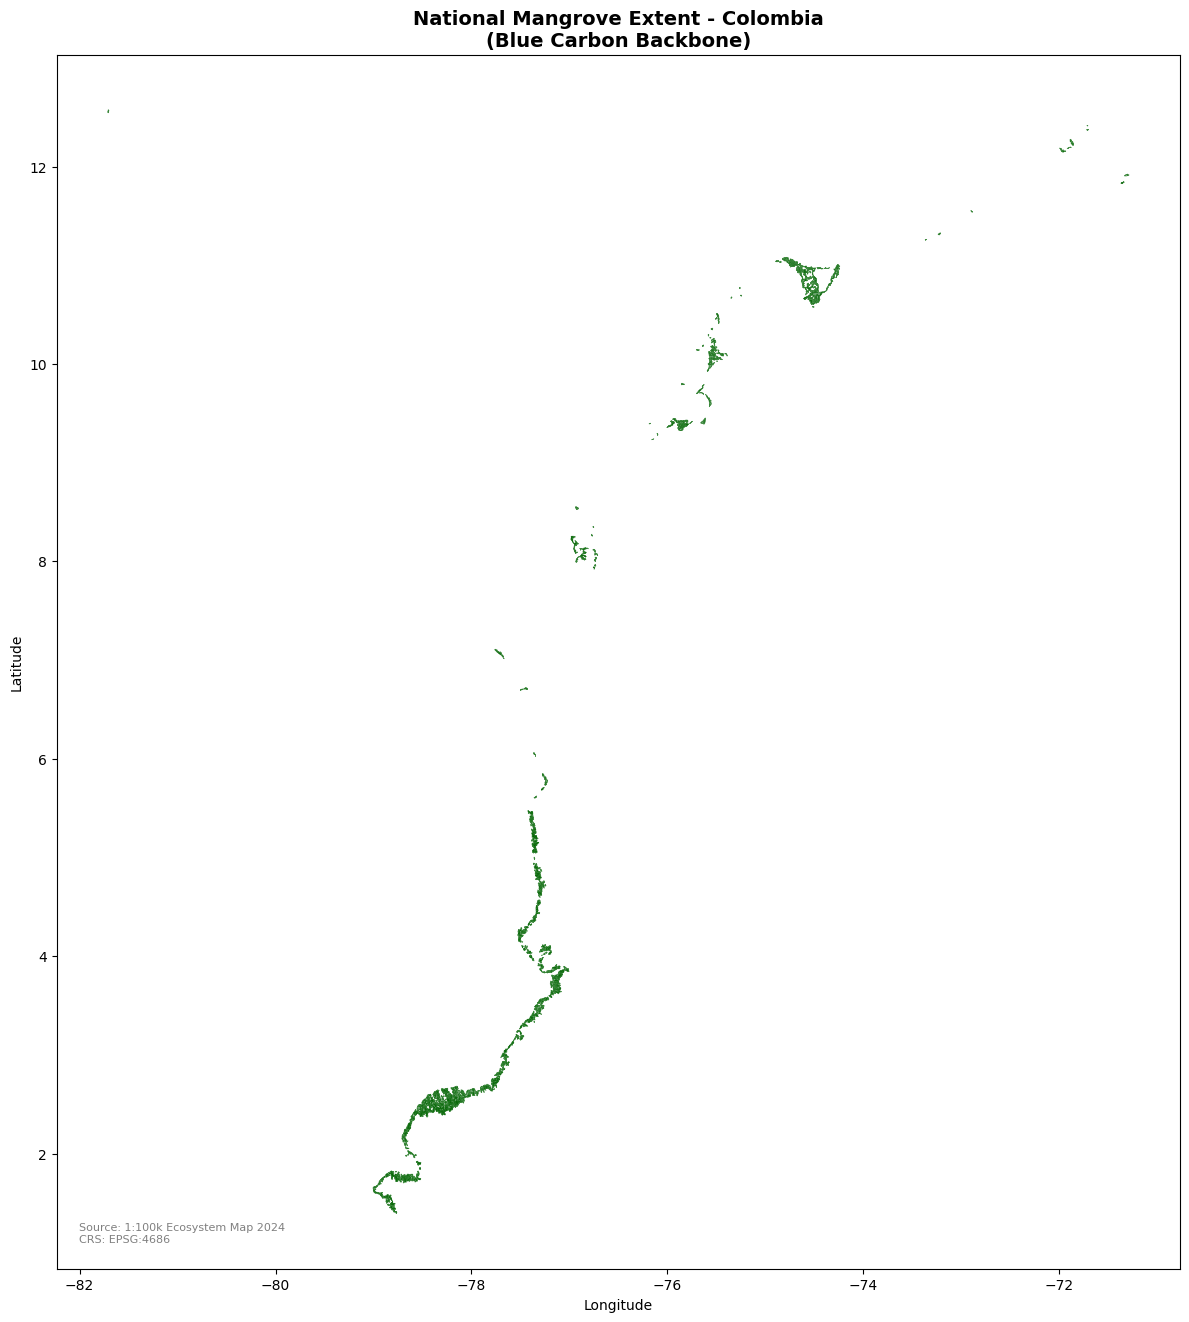

Saved: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/map_national_mangroves.png


In [17]:
# -----------------------------------------------------------------------------
# Map 1: National Overview - Dissolved Mangrove Extent
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Plot dissolved mangroves
gdf_dissolved.plot(
    ax=ax,
    color=MANGROVE_GREEN,
    edgecolor='darkgreen',
    linewidth=0.5,
    alpha=0.7
)

# Formatting
ax.set_title('National Mangrove Extent - Colombia\n(Blue Carbon Backbone)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

# Add annotation
ax.annotate(
    f'Source: 1:100k Ecosystem Map 2024\nCRS: {gdf_dissolved.crs}',
    xy=(0.02, 0.02), xycoords='axes fraction',
    fontsize=8, color='gray',
    verticalalignment='bottom'
)

plt.tight_layout()
plt.savefig(DATA_PROCESSED / 'map_national_mangroves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {DATA_PROCESSED / 'map_national_mangroves.png'}")

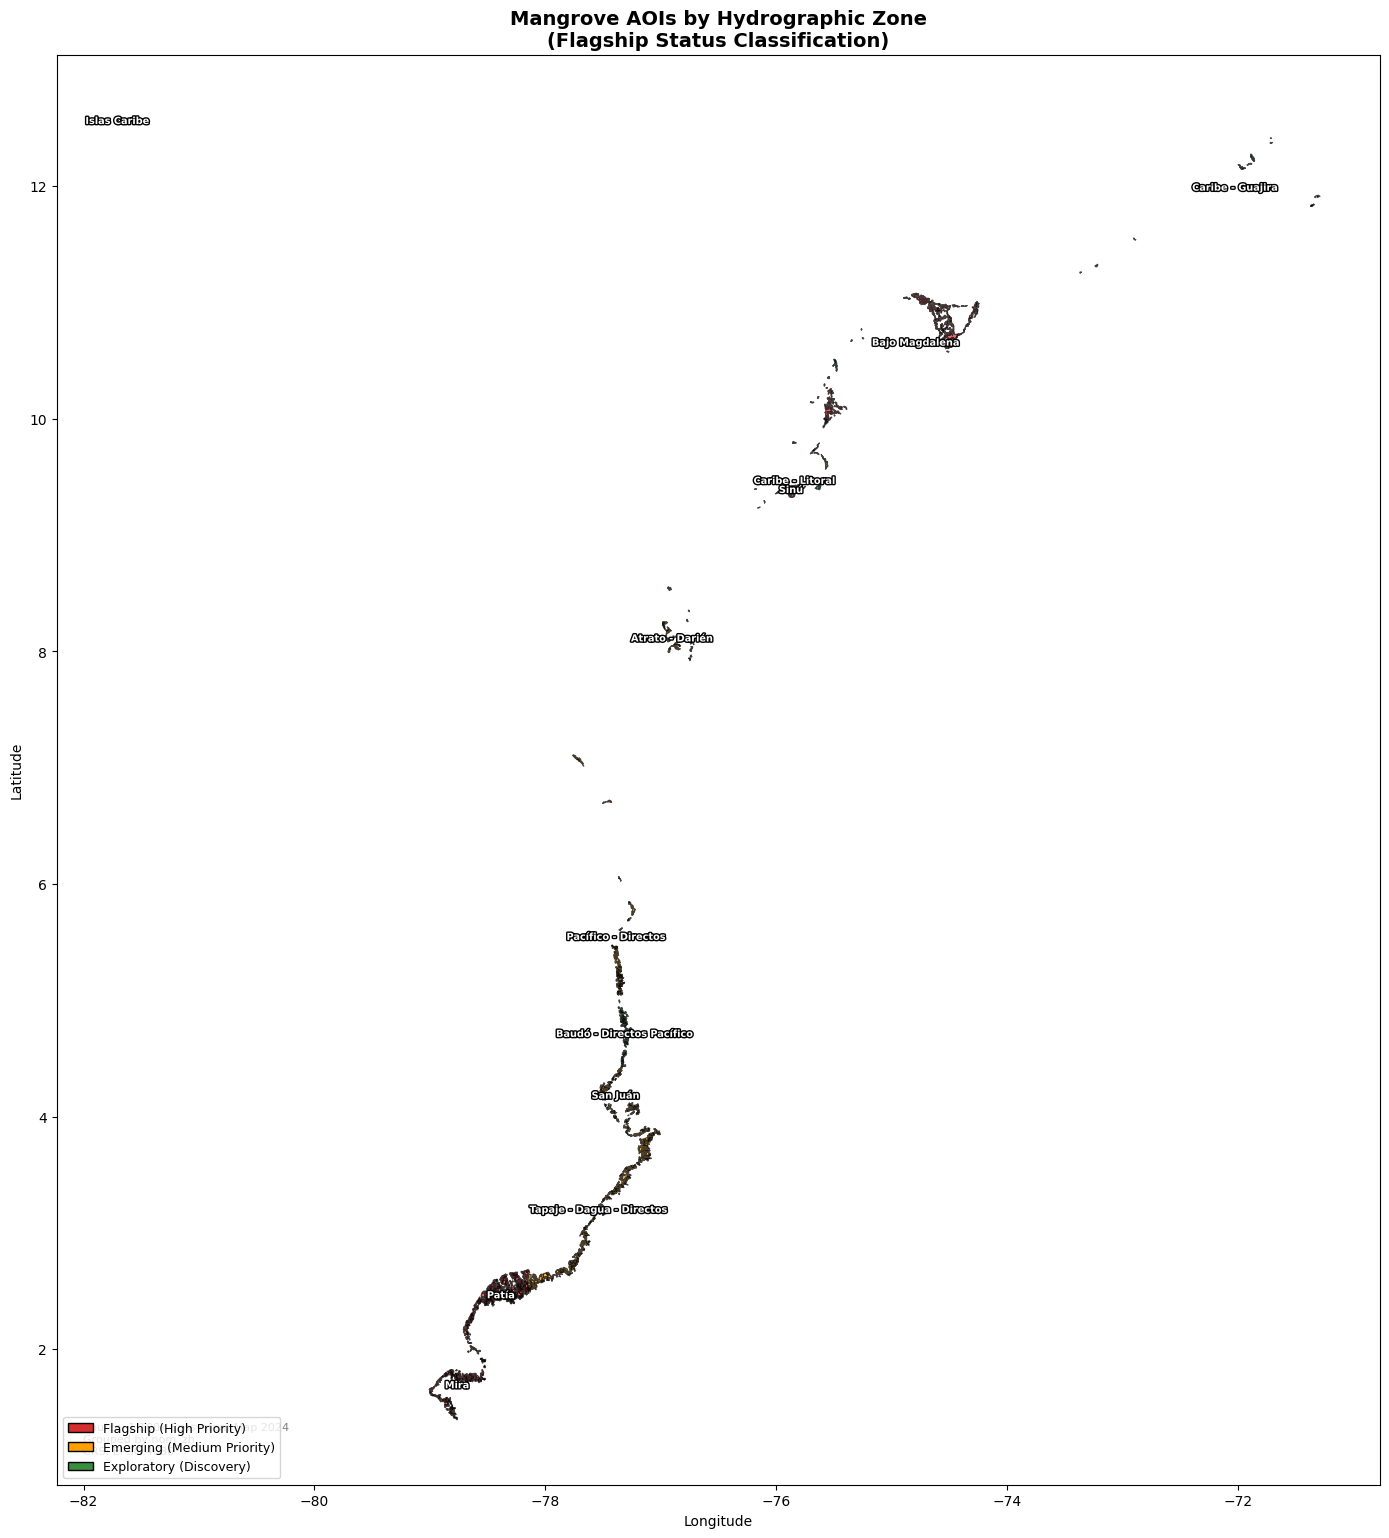

Saved: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/map_hydrographic_aois.png


In [18]:
# -----------------------------------------------------------------------------
# Map 2: Hydrographic AOI Map (colored by nom_zh with flagship status)
# -----------------------------------------------------------------------------
from matplotlib.patches import Patch
from matplotlib.patheffects import withStroke

fig, ax = plt.subplots(1, 1, figsize=(14, 16))

# Use original CRS (geographic) for visualization
gdf_viz = gdf_by_zh.copy()
gdf_viz['flagship_status'] = gdf_viz['nom_zh'].apply(assign_flagship_status)

# Create color mapping
gdf_viz['color'] = gdf_viz['flagship_status'].map(STATUS_COLORS)

# Plot with colors by flagship status
gdf_viz.plot(
    ax=ax,
    color=gdf_viz['color'],
    edgecolor='black',
    linewidth=0.8,
    alpha=0.7
)

# Add labels for each zone
for idx, row in gdf_viz.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(
        row['nom_zh'],
        xy=(centroid.x, centroid.y),
        fontsize=7,
        ha='center',
        va='center',
        fontweight='bold',
        color='white',
        path_effects=[
            withStroke(linewidth=2, foreground='black')
        ]
    )

# Legend
legend_elements = [
    Patch(facecolor=STATUS_COLORS['flagship'], edgecolor='black', label='Flagship (High Priority)'),
    Patch(facecolor=STATUS_COLORS['emerging'], edgecolor='black', label='Emerging (Medium Priority)'),
    Patch(facecolor=STATUS_COLORS['exploratory'], edgecolor='black', label='Exploratory (Discovery)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=9)

# Formatting
ax.set_title('Mangrove AOIs by Hydrographic Zone\n(Flagship Status Classification)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

# Add annotation
ax.annotate(
    f'Source: 1:100k Ecosystem Map 2024\nGrouped by nom_zh\nCRS: {gdf_viz.crs}',
    xy=(0.02, 0.02), xycoords='axes fraction',
    fontsize=8, color='gray',
    verticalalignment='bottom'
)

plt.tight_layout()
plt.savefig(DATA_PROCESSED / 'map_hydrographic_aois.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {DATA_PROCESSED / 'map_hydrographic_aois.png'}")

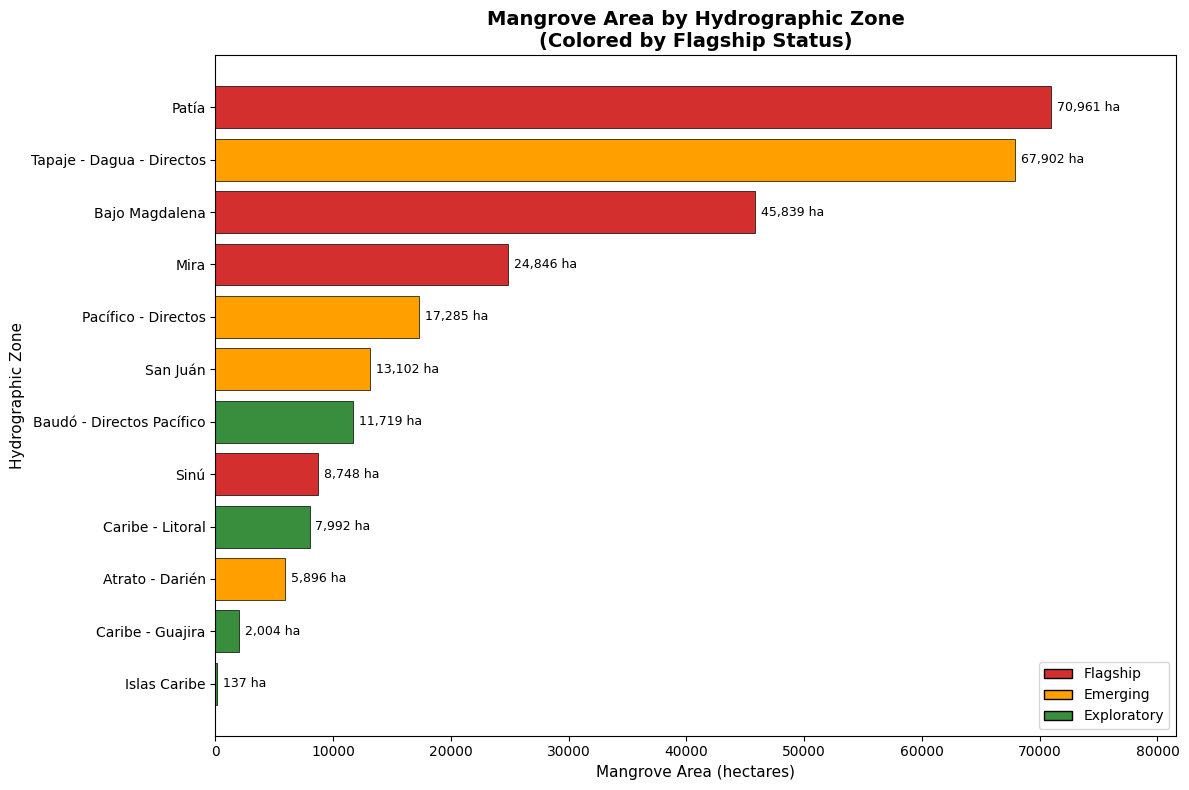

Saved: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/chart_area_by_zone.png


In [19]:
# -----------------------------------------------------------------------------
# Chart 1: Priority Ranking Bar Chart (by Area)
# -----------------------------------------------------------------------------
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Sort by area
plot_df = gdf_metrics.sort_values('area_ha_computed', ascending=True).copy()

# Create bar colors based on flagship status
bar_colors = plot_df['flagship_status'].map(STATUS_COLORS)

# Horizontal bar chart
bars = ax.barh(
    plot_df['nom_zh'],
    plot_df['area_ha_computed'],
    color=bar_colors,
    edgecolor='black',
    linewidth=0.5
)

# Add value labels
for bar, val in zip(bars, plot_df['area_ha_computed']):
    ax.text(
        bar.get_width() + 500,
        bar.get_y() + bar.get_height()/2,
        f'{val:,.0f} ha',
        va='center',
        fontsize=9
    )

# Legend
legend_elements = [
    Patch(facecolor=STATUS_COLORS['flagship'], edgecolor='black', label='Flagship'),
    Patch(facecolor=STATUS_COLORS['emerging'], edgecolor='black', label='Emerging'),
    Patch(facecolor=STATUS_COLORS['exploratory'], edgecolor='black', label='Exploratory')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Formatting
ax.set_xlabel('Mangrove Area (hectares)', fontsize=11)
ax.set_ylabel('Hydrographic Zone', fontsize=11)
ax.set_title('Mangrove Area by Hydrographic Zone\n(Colored by Flagship Status)', fontsize=14, fontweight='bold')
ax.set_xlim(0, plot_df['area_ha_computed'].max() * 1.15)

plt.tight_layout()
plt.savefig(DATA_PROCESSED / 'chart_area_by_zone.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {DATA_PROCESSED / 'chart_area_by_zone.png'}")

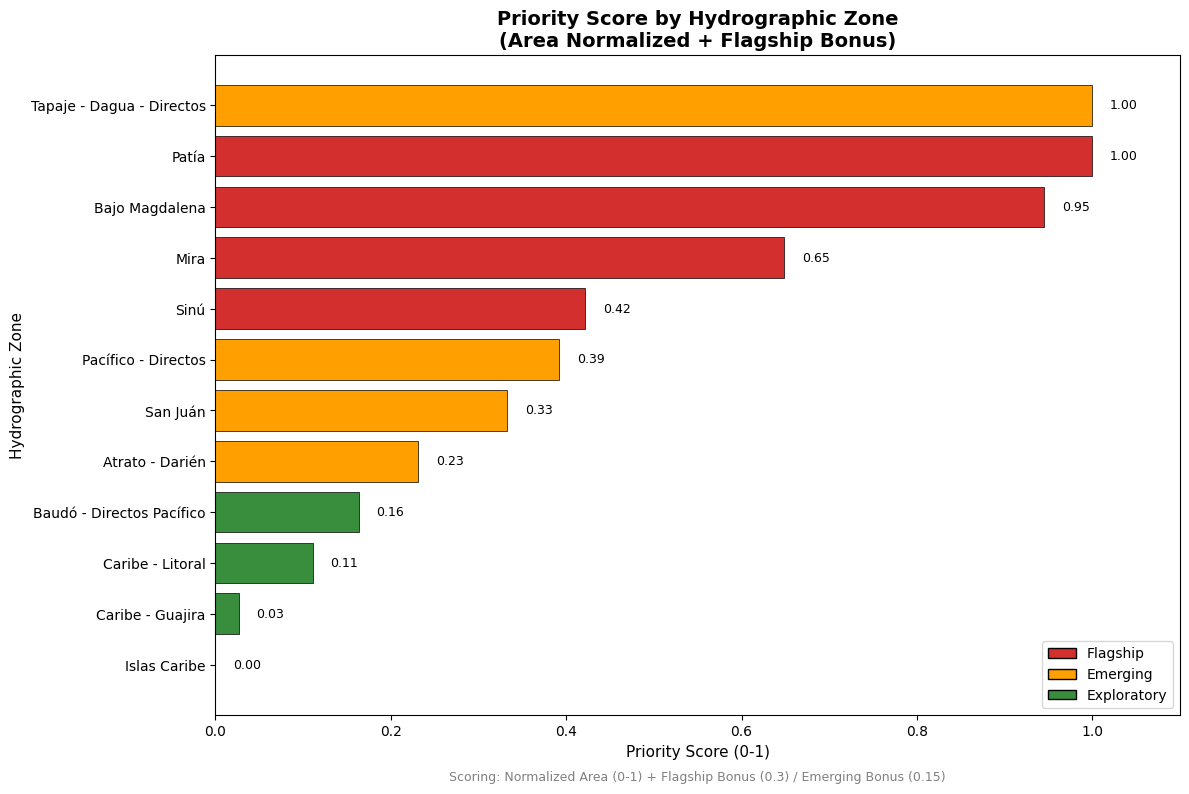

Saved: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/chart_priority_score.png


In [20]:
# -----------------------------------------------------------------------------
# Chart 2: Priority Score Ranking
# -----------------------------------------------------------------------------
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Sort by priority score
plot_df = gdf_metrics.sort_values('priority_score', ascending=True).copy()

# Create bar colors based on flagship status
bar_colors = plot_df['flagship_status'].map(STATUS_COLORS)

# Horizontal bar chart
bars = ax.barh(
    plot_df['nom_zh'],
    plot_df['priority_score'],
    color=bar_colors,
    edgecolor='black',
    linewidth=0.5
)

# Add value labels
for bar, val in zip(bars, plot_df['priority_score']):
    ax.text(
        bar.get_width() + 0.02,
        bar.get_y() + bar.get_height()/2,
        f'{val:.2f}',
        va='center',
        fontsize=9
    )

# Legend
legend_elements = [
    Patch(facecolor=STATUS_COLORS['flagship'], edgecolor='black', label='Flagship'),
    Patch(facecolor=STATUS_COLORS['emerging'], edgecolor='black', label='Emerging'),
    Patch(facecolor=STATUS_COLORS['exploratory'], edgecolor='black', label='Exploratory')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Formatting
ax.set_xlabel('Priority Score (0-1)', fontsize=11)
ax.set_ylabel('Hydrographic Zone', fontsize=11)
ax.set_title('Priority Score by Hydrographic Zone\n(Area Normalized + Flagship Bonus)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.1)

# Add explanation annotation
ax.annotate(
    f'Scoring: Normalized Area (0-1) + Flagship Bonus ({FLAGSHIP_BONUS}) / Emerging Bonus ({EMERGING_BONUS})',
    xy=(0.5, -0.1), xycoords='axes fraction',
    fontsize=9, color='gray',
    ha='center'
)

plt.tight_layout()
plt.savefig(DATA_PROCESSED / 'chart_priority_score.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {DATA_PROCESSED / 'chart_priority_score.png'}")

## 4. Export AOI Geometries for Earthm.ai

In [21]:
# -----------------------------------------------------------------------------
# Helper function to create AOI ID from nom_zh
# -----------------------------------------------------------------------------
def create_aoi_id(nom_zh):
    """Create a standardized AOI ID from the zone name."""
    # Normalize and clean the name
    normalized = normalize_zone_name(nom_zh)
    # Replace spaces and special characters with underscores
    clean = re.sub(r'[^a-z0-9]', '_', normalized)
    # Remove multiple underscores
    clean = re.sub(r'_+', '_', clean)
    # Remove leading/trailing underscores
    clean = clean.strip('_')
    return f"COL_{clean.upper()}_MANGROVE"

def create_aoi_name(nom_zh, flagship_status):
    """Create a human-readable AOI name."""
    # Add context based on flagship status
    suffix_map = {
        'Sinu': 'Cispata Mangroves',
        'Bajo Magdalena': 'Cienaga Grande Mangroves',
        'Patia': 'Pacific Complex Mangroves',
        'Mira': 'Pacific Mangroves'
    }
    
    # Check for special naming
    for key, suffix in suffix_map.items():
        if key.lower() in normalize_zone_name(nom_zh):
            return f"{nom_zh} - {suffix}"
    
    return f"{nom_zh} Mangroves"

# Test
print("AOI ID examples:")
for nom_zh in ['Sinu', 'Bajo Magdalena', 'Patia - Directos']:
    print(f"  {nom_zh} -> {create_aoi_id(nom_zh)}")

AOI ID examples:
  Sinu -> COL_SINU_MANGROVE
  Bajo Magdalena -> COL_BAJO_MAGDALENA_MANGROVE
  Patia - Directos -> COL_PATIA_DIRECTOS_MANGROVE


In [22]:
# -----------------------------------------------------------------------------
# Export individual AOI GeoJSON files
# -----------------------------------------------------------------------------

# Use the original CRS (EPSG:4686) for export
gdf_export = gdf_by_zh.copy()

# Add metrics from the computed dataframe
metrics_to_add = ['area_ha_computed', 'perimeter_km', 'flagship_status', 'priority_score', 'centroid_lat', 'centroid_lon']
for col in metrics_to_add:
    gdf_export[col] = gdf_metrics.set_index('nom_zh').loc[gdf_export['nom_zh'], col].values

# Add standardized fields
gdf_export['aoi_id'] = gdf_export['nom_zh'].apply(create_aoi_id)
gdf_export['aoi_name'] = gdf_export.apply(lambda r: create_aoi_name(r['nom_zh'], r['flagship_status']), axis=1)
gdf_export['source_layer'] = SOURCE_LAYER
gdf_export['filter_logic'] = FILTER_LOGIC

exported_files = []
metadata_rows = []

for idx, row in gdf_export.iterrows():
    nom_zh = row['nom_zh']
    aoi_id = row['aoi_id']
    
    # Create single-feature GeoDataFrame with essential fields
    aoi_gdf = gpd.GeoDataFrame(
        [{
            'aoi_id': row['aoi_id'],
            'aoi_name': row['aoi_name'],
            'nom_zh': row['nom_zh'],
            'source_layer': row['source_layer'],
            'area_ha': round(row['area_ha_computed'], 1),
            'flagship_status': row['flagship_status'],
            'priority_score': round(row['priority_score'], 3),
            'geometry': row.geometry
        }],
        crs=gdf_export.crs
    )
    
    # Generate filename
    filename = f"{aoi_id.lower()}.geojson"
    filepath = DATA_AOIS / filename
    
    # Export
    aoi_gdf.to_file(filepath, driver='GeoJSON')
    exported_files.append(filename)
    
    # Prepare metadata row
    notes = ""
    if row['flagship_status'] == 'flagship':
        if 'sinu' in normalize_zone_name(nom_zh):
            notes = "Overlaps Vida Manglar VCS 2290 AOI; Cispata Bay region"
        elif 'bajo magdalena' in normalize_zone_name(nom_zh):
            notes = "Includes Cienaga Grande de Santa Marta; INVEMAR primary research area"
        elif 'patia' in normalize_zone_name(nom_zh):
            notes = "Pacific coast complex; high AGB literature base"
        elif 'mira' in normalize_zone_name(nom_zh):
            notes = "Southern Pacific coast; near Ecuador border"
    elif row['flagship_status'] == 'emerging':
        notes = "Strategic area with substantial mangrove extent; fewer formal blue carbon projects"
    else:
        notes = "Exploratory zone; potential for new blue carbon opportunity discovery"
    
    metadata_rows.append({
        'aoi_id': row['aoi_id'],
        'aoi_name': row['aoi_name'],
        'nom_zh': row['nom_zh'],
        'area_ha': round(row['area_ha_computed'], 1),
        'flagship_status': row['flagship_status'],
        'priority_score': round(row['priority_score'], 3),
        'data_source': f"data/raw/Mapa_Ecosistemas_Continentales_Costeros_Marinos_100K_2024/SHAPE/{SOURCE_LAYER}",
        'filter_logic': FILTER_LOGIC,
        'notes': notes
    })

print(f"Exported {len(exported_files)} AOI GeoJSON files to: {DATA_AOIS}")
print("\nFiles created:")
for f in sorted(exported_files):
    print(f"  - {f}")

Exported 12 AOI GeoJSON files to: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/aois

Files created:
  - col_atrato_darien_mangrove.geojson
  - col_bajo_magdalena_mangrove.geojson
  - col_baudo_directos_pacifico_mangrove.geojson
  - col_caribe_guajira_mangrove.geojson
  - col_caribe_litoral_mangrove.geojson
  - col_islas_caribe_mangrove.geojson
  - col_mira_mangrove.geojson
  - col_pacifico_directos_mangrove.geojson
  - col_patia_mangrove.geojson
  - col_san_juan_mangrove.geojson
  - col_sinu_mangrove.geojson
  - col_tapaje_dagua_directos_mangrove.geojson


In [23]:
# -----------------------------------------------------------------------------
# Export metadata CSV
# -----------------------------------------------------------------------------

metadata_df = pd.DataFrame(metadata_rows)
metadata_df = metadata_df.sort_values('priority_score', ascending=False)
metadata_df.to_csv(METADATA_CSV, index=False)

print(f"Exported metadata: {METADATA_CSV}")
print("\nMetadata preview:")
metadata_df[['aoi_id', 'aoi_name', 'area_ha', 'flagship_status', 'priority_score']]

Exported metadata: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/ai_docs/blue_carbon_aoi_metadata.csv

Metadata preview:


,aoi_id,aoi_name,area_ha,flagship_status,priority_score
8,COL_PATIA_MANGROVE,Patía - Pacific Complex Mangroves,70960.6,flagship,1.000
11,COL_TAPAJE_DAGUA_DIRECTOS_MANGROVE,Tapaje - Dagua - Directos Mangroves,67901.5,emerging,1.000
1,COL_BAJO_MAGDALENA_MANGROVE,Bajo Magdalena - Cienaga Grande Mangroves,45839.1,flagship,0.945
6,COL_MIRA_MANGROVE,Mira - Pacific Mangroves,24846.0,flagship,0.649
10,COL_SINU_MANGROVE,Sinú - Cispata Mangroves,8748.4,flagship,0.422
7,COL_PACIFICO_DIRECTOS_MANGROVE,Pacífico - Directos Mangroves,17284.6,emerging,0.392
9,COL_SAN_JUAN_MANGROVE,San Juán Mangroves,13102.0,emerging,0.333
0,COL_ATRATO_DARIEN_MANGROVE,Atrato - Darién Mangroves,5895.6,emerging,0.231
2,COL_BAUDO_DIRECTOS_PACIFICO_MANGROVE,Baudó - Directos Pacífico Mangroves,11719.4,exploratory,0.164
4,COL_CARIBE_LITORAL_MANGROVE,Caribe - Litoral Mangroves,7992.3,exploratory,0.111


## 5. Verification & Summary

In [24]:
# -----------------------------------------------------------------------------
# Verify all outputs exist
# -----------------------------------------------------------------------------
print("=" * 60)
print("OUTPUT VERIFICATION")
print("=" * 60)

# Check CSV outputs
print("\n1. CSV Outputs:")
for csv_path in [CANDIDATES_CSV, METADATA_CSV]:
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        print(f"   [OK] {csv_path.name}: {len(df)} rows")
    else:
        print(f"   [MISSING] {csv_path.name}")

# Check GeoJSON outputs
print("\n2. AOI GeoJSON Files:")
aoi_files = list(DATA_AOIS.glob('*.geojson'))
print(f"   Total files: {len(aoi_files)}")
for f in sorted(aoi_files)[:5]:
    gdf = gpd.read_file(f)
    print(f"   [OK] {f.name}: {len(gdf)} feature(s), CRS={gdf.crs}")
if len(aoi_files) > 5:
    print(f"   ... and {len(aoi_files) - 5} more files")

# Check PNG outputs
print("\n3. Visualization Outputs:")
for png_name in ['map_national_mangroves.png', 'map_hydrographic_aois.png', 'chart_area_by_zone.png', 'chart_priority_score.png']:
    png_path = DATA_PROCESSED / png_name
    if png_path.exists():
        print(f"   [OK] {png_name}")
    else:
        print(f"   [MISSING] {png_name}")

OUTPUT VERIFICATION

1. CSV Outputs:
   [OK] blue_carbon_candidates.csv: 12 rows
   [OK] blue_carbon_aoi_metadata.csv: 12 rows

2. AOI GeoJSON Files:
   Total files: 12
   [OK] col_atrato_darien_mangrove.geojson: 1 feature(s), CRS=EPSG:4686
   [OK] col_bajo_magdalena_mangrove.geojson: 1 feature(s), CRS=EPSG:4686
   [OK] col_baudo_directos_pacifico_mangrove.geojson: 1 feature(s), CRS=EPSG:4686
   [OK] col_caribe_guajira_mangrove.geojson: 1 feature(s), CRS=EPSG:4686
   [OK] col_caribe_litoral_mangrove.geojson: 1 feature(s), CRS=EPSG:4686
   ... and 7 more files

3. Visualization Outputs:
   [OK] map_national_mangroves.png
   [OK] map_hydrographic_aois.png
   [OK] chart_area_by_zone.png
   [OK] chart_priority_score.png


In [25]:
# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\nTotal hydrographic zones: {len(gdf_metrics)}")
print(f"Total mangrove area: {gdf_metrics['area_ha_computed'].sum():,.0f} hectares")

print("\nBy flagship status:")
for status in ['flagship', 'emerging', 'exploratory']:
    subset = gdf_metrics[gdf_metrics['flagship_status'] == status]
    print(f"  {status.capitalize()}: {len(subset)} zones, {subset['area_ha_computed'].sum():,.0f} ha")

print("\nTop 5 AOIs by priority score:")
top5 = gdf_metrics.nlargest(5, 'priority_score')[['nom_zh', 'area_ha_computed', 'flagship_status', 'priority_score']]
for idx, row in top5.iterrows():
    print(f"  {row['nom_zh']}: {row['area_ha_computed']:,.0f} ha ({row['flagship_status']}, score={row['priority_score']:.3f})")

SUMMARY STATISTICS

Total hydrographic zones: 12
Total mangrove area: 276,430 hectares

By flagship status:
  Flagship: 4 zones, 150,394 ha
  Emerging: 4 zones, 104,184 ha
  Exploratory: 4 zones, 21,852 ha

Top 5 AOIs by priority score:
  Patía: 70,961 ha (flagship, score=1.000)
  Tapaje - Dagua - Directos: 67,902 ha (emerging, score=1.000)
  Bajo Magdalena: 45,839 ha (flagship, score=0.945)
  Mira: 24,846 ha (flagship, score=0.649)
  Sinú: 8,748 ha (flagship, score=0.422)


## 6. Provenance Log

In [26]:
# -----------------------------------------------------------------------------
# Provenance Information
# -----------------------------------------------------------------------------
print("=" * 60)
print("PROVENANCE LOG")
print("=" * 60)

print(f"""
Processing Date: {datetime.now().isoformat()}

Input Data:
  - Source: 1:100k Ecosystem Map of Colombia (2024)
  - Layer: {SOURCE_LAYER}
  - Filter: {FILTER_LOGIC}
  - Original CRS: {CRS_ORIGINAL} (MAGNA-SIRGAS geographic)

Processing:
  - Area calculations: Reprojected to {CRS_EQUAL_AREA} (MAGNA-SIRGAS / Colombia Bogota zone)
  - Grouping: Dissolved by nom_zh (hydrographic zone)
  
Flagship Classification:
  - Flagship zones: {', '.join(FLAGSHIP_ZONES)}
  - Emerging zones: {', '.join(EMERGING_ZONES)}
  - All others: Exploratory

Priority Scoring:
  - Base: Normalized area (0-1 scale, min-max)
  - Flagship bonus: +{FLAGSHIP_BONUS}
  - Emerging bonus: +{EMERGING_BONUS}
  - Final score capped at 1.0

Outputs:
  - Summary CSV: {CANDIDATES_CSV}
  - Metadata CSV: {METADATA_CSV}
  - AOI GeoJSONs: {DATA_AOIS}/

Software Versions:
  - geopandas: {gpd.__version__}
  - pandas: {pd.__version__}
  - numpy: {np.__version__}
""")

PROVENANCE LOG

Processing Date: 2025-11-26T11:10:48.962099

Input Data:
  - Source: 1:100k Ecosystem Map of Colombia (2024)
  - Layer: e_eccmc_100K_2024.shp
  - Filter: u_sintesis contains 'manglar' (case-insensitive)
  - Original CRS: EPSG:4686 (MAGNA-SIRGAS geographic)

Processing:
  - Area calculations: Reprojected to EPSG:3116 (MAGNA-SIRGAS / Colombia Bogota zone)
  - Grouping: Dissolved by nom_zh (hydrographic zone)

Flagship Classification:
  - Flagship zones: Sinu, Bajo Magdalena, Patia, Mira
  - Emerging zones: San Juan, Pacifico - Directos, Atrato - Darien, Tapaje - Dagua - Directos
  - All others: Exploratory

Priority Scoring:
  - Base: Normalized area (0-1 scale, min-max)
  - Flagship bonus: +0.3
  - Emerging bonus: +0.15
  - Final score capped at 1.0

Outputs:
  - Summary CSV: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/data/processed/blue_carbon_candidates.csv
  - Metadata CSV: /Users/jaygut/Documents/Side_Projects/marine-gis-pilot-data/ai_docs/blue_carbo